In [18]:
using Images

if nprocs() < 4
    addprocs(4)
end;

In [2]:
@everywhere @inline function hsv2rgb(h, s, v)
    const c = v * s
    const x = c * (1 - abs(((h/60) % 2) - 1))
    const m = v - c
 
    const r,g,b =
        if h < 60
            (c, x, 0)
        elseif h < 120
            (x, c, 0)
        elseif h < 180
            (0, c, x)
        elseif h < 240
            (0, x, c)
        elseif h < 300
            (x, 0, c)
        else
            (c, 0, x)
        end
 
    (r + m), (b + m), (g + m)
end

@everywhere function pixel_mandelbrot(jobs, results)
    while true
        
        (x, y, w, h, zoom, moveX, moveY, maxIter) = take!(jobs)

        i = maxIter
        const c = Complex(
            (2*x - w) / (w * zoom) + moveX,
            (2*y - h) / (h * zoom) + moveY
        )
        z = c
        while abs(z) < 2 && (i -= 1) > 0
            z = z^2 + c
        end

        put!(results, (x, y, hsv2rgb(i / maxIter * 360, 1, i / maxIter)))
    end
end

In [16]:
const zoom  = 0.5
const moveX = -0.5
const moveY = 0
const maxIter = 30

w, h = 200, 200

jobs = RemoteChannel(()->Channel{Any}(w*h));
results = RemoteChannel(()->Channel{Any}(w*h));

function make_jobs(w, h)
     for x in 1:w
        for y in 1:h
            put!(jobs, (x, y, w, h, zoom, moveX, moveY, maxIter))
        end
    end
end
 
function mandelbrot(save_png)
    const img = Array{RGB{Float64}}(h, w)
    
    @schedule make_jobs(w, h);
    
    for p in workers()
       @async remote_do(pixel_mandelbrot, p, jobs, results)
    end
    
    t = w*h
    while t > 0
        x, y, (r, g, b) = take!(results)
        img[y,x] = RGB{Float64}(r, g, b)
        
        t = t - 1
    end
    img
end 
img = mandelbrot(true);

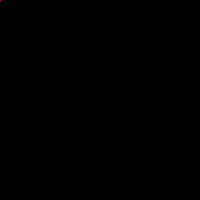

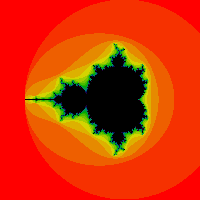

In [17]:
img